In [1]:
import time

from numba import cuda
import numpy as np # Arrays in Python
from matplotlib import pyplot as plt # Plotting library

from math import sin, cos, pi

In [2]:
# Repeatable results
np.random.seed(0)

# Define the observed signal
signal = np.random.normal(size=512, loc=0, scale=1).astype(np.float32)

In [3]:
@cuda.jit
def dft_parallel(samples, aantalsamples, frequencies):
    # Calculate the thread's absolute position within the grid
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    sample = samples[x]


    for k in range(frequencies.shape[1]):
        prod_real = sample * (cos(2 * pi * k * x / aantalsamples))
        prod_im   = sample * (-1) * sin(2 * pi * k * x / aantalsamples)
        cuda.atomic.add(frequencies[0], k, prod_real)
        cuda.atomic.add(frequencies[1], k, prod_im)

In [4]:
def synchronous_kernel_timeit(kernel, number=1, repeat=1):
    times = []
    for r in range(repeat):
        start = time.time()
        for n in range(number):
            kernel()
            cuda.synchronize()  # Do not queue up, instead wait for all previous kernel launches to finish executing
        stop = time.time()
        times.append((stop - start) / number)
    return times[0] if len(times) == 1 else times

In [5]:
# Define the sampling rate and observation time
SAMPLING_RATE_HZ = 100
TIME_S = 20 # Use only integers for correct DFT results
N = SAMPLING_RATE_HZ * TIME_S

# Define sample times
x = np.linspace(0, TIME_S, int(N), endpoint=False)

# Create signal
sigs = [ np.sin(x * (2*pi) * (i+1) * 2 + i*pi/16) / (i+1) for i in range(24) ]
sig_sum = np.array(sum(sigs) / len(sigs)) + 0.05

# Create w-array for use in kernel
frequencies = np.zeros([2, int(N/2+1)])
#print("\nMatrix c : \n", frequencies)


Matrix c : 
 [ 1.00000000e+02+0.00000000e+00j  1.92741656e-13+7.25574657e-14j
  4.68149824e-14+1.57002341e-13j ...  3.56416285e-14-1.83463216e-13j
 -1.83448742e-13+5.78448503e-13j -1.01526426e-13+4.09883424e-13j]


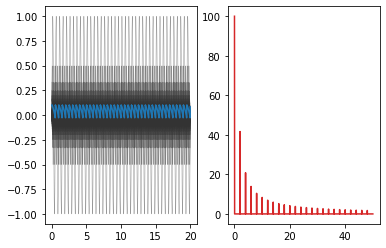

In [6]:
# Test results ( & compile function at this first call!)
dft_parallel[20, 100](sig_sum, N, frequencies)

sumfreqs = np.zeros(int(N/2+1), dtype=np.complex)
for k in range(len(frequencies[0])):
    sumfreqs[k] = frequencies[0][k] + frequencies[1][k] * 1j

print("\nMatrix c : \n", sumfreqs)

# Plot to evaluate whether the results are as expected
fig, (ax1, ax2) = plt.subplots(1, 2)

# Calculate the appropriate X-axis for the frequency components
xf = np.linspace(0, SAMPLING_RATE_HZ/2, int(N/2+1), endpoint=True)

# Plot all of the signal components and their sum
for sig in sigs:
    ax1.plot( x, sig, lw=0.5, color='#333333', alpha=0.5 )
ax1.plot( x, sig_sum )

# Plot the frequency components
ax2.plot( xf, abs(sumfreqs), color='C3' )

plt.show()

In [7]:
t_par = synchronous_kernel_timeit(lambda: dft_parallel[20,100](sig_sum, N, frequencies), number=10)
print(t_par, "seconds on average")

0.7190773963928223 seconds on average


In [8]:
# Use striding-loops to reconfigure thread-count
@cuda.jit
def dft_parallel_withstride(samples, aantalsamples, frequencies):
    # Calculate the thread's absolute position within the grid
    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    
    # Set stride equal to the number of threads we have available in the x-direction
    stride = cuda.gridDim.x * cuda.blockDim.x
    
    for x in range (i, sig_sum.shape[0], stride):
        sample = samples[x]

        for k in range(frequencies.shape[1]):
            prod_real = sample * (cos(2 * pi * k * x / aantalsamples))
            prod_im   = sample * (-1) * sin(2 * pi * k * x / aantalsamples)
            cuda.atomic.add(frequencies[0], k, prod_real)
            cuda.atomic.add(frequencies[1], k, prod_im)

In [9]:
t_10th = synchronous_kernel_timeit(lambda: dft_parallel_withstride[2,100](sig_sum, N, frequencies), number=10)
print(t_10th, "seconds on average for 200 threads")

1.8105362892150878 seconds on average for 200 threads


In [10]:
t_5th = synchronous_kernel_timeit(lambda: dft_parallel_withstride[4, 100](sig_sum, N, frequencies), number=10)
print(t_5th, "seconds on average for 400 threads")

1.0678889751434326 seconds on average for 400 threads


In [11]:
t_600 = synchronous_kernel_timeit(lambda: dft_parallel_withstride[6, 100](sig_sum, N, frequencies), number=10)
print(t_600, "seconds on average for 600 threads")

0.8269631385803222 seconds on average for 600 threads


In [12]:
t_800 = synchronous_kernel_timeit(lambda: dft_parallel_withstride[8, 100](sig_sum, N, frequencies), number=10)
print(t_800, "seconds on average for 800 threads")

0.7505666971206665 seconds on average for 800 threads


In [13]:
t_half = synchronous_kernel_timeit(lambda: dft_parallel_withstride[10, 100](sig_sum, N, frequencies), number=10)
print(t_half, "seconds on average for 1000 threads")

0.9411421298980713 seconds on average for 1000 threads


In [14]:
t_1500 = synchronous_kernel_timeit(lambda: dft_parallel_withstride[15, 100](sig_sum, N, frequencies), number=10)
print(t_1500, "seconds on average for 1500 threads")

0.8126604080200195 seconds on average for 1500 threads


In [15]:
t_par = synchronous_kernel_timeit(lambda: dft_parallel_withstride[20,100](sig_sum, N, frequencies), number=10)
print(t_par, "seconds on average for 2000 threads")

0.8249121904373169 seconds on average for 2000 threads


In [16]:
t_3000 = synchronous_kernel_timeit(lambda: dft_parallel_withstride[30, 100](sig_sum, N, frequencies), number=10)
print(t_3000, "seconds on average for 3000 threads")

0.8370323657989502 seconds on average for 3000 threads


In [17]:
device = cuda.get_current_device()
print(device)

<CUDA device 0 'b'GeForce GT 630M''>


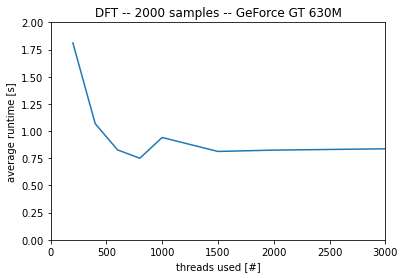

In [70]:
from matplotlib import pyplot as plt # Plotting library
plt.close()

xvals = [200,400,600,800,1000,1500,2000,3000]
yvals = [t_10th, t_5th, t_600, t_800, t_half, t_1500, t_par, t_3000]

fig, ax1 = plt.subplots()
ax1.plot(xvals, yvals)
ax1.set_xlim([0, 3000])
ax1.set_ylim([0, 2])
ax1.set_ylabel("average runtime [s]")
ax1.set_xlabel("threads used [#]")
ax1.set_title("DFT -- 2000 samples -- GeForce GT 630M")
plt.savefig("DFTsamples.jpg")
plt.show()

#plt.plot(xvals, yvals)
#plt.ylabel("average runtime")
#plt.xlabel("threads used")
#plt.title("DFT -- 2000 samples -- GeForce GT 630M")

In [67]:
t_100 = synchronous_kernel_timeit(lambda: dft_parallel_withstride[1, 100](sig_sum, N, frequencies), number=10)
print(t_3000, "seconds on average for 100 threads")

CudaAPIError: [702] Call to cuMemcpyDtoH results in CUDA_ERROR_LAUNCH_TIMEOUT